<a href="https://colab.research.google.com/github/aymenkani/lab-9-lab-9-comparing-regression-models_random-forest-vs-xboost/blob/main/lab_9_comparing_regression_models_random_forest_vs_xboost_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Advanced Regression - A Comparison of Random Forest and XGBoost

**Estimated time needed:** 25 minutes

## Objectives

After completing this lab, you will be able to:

- Load and preprocess a classic dataset for regression.
- Implement and train both Random Forest and XGBoost regression models using scikit-learn.
- Measure and compare the performance of these two models in terms of both accuracy (MSE, R²) and computational speed.

## Introduction

In this lab, we will explore and compare two powerful ensemble machine learning models: **Random Forest** and **XGBoost (Extreme Gradient Boosting)**. Our goal is to predict the fuel efficiency of vehicles from the late 1970s and early 1980s using the well-known "Auto MPG" dataset.

We will evaluate these models on two key dimensions: **predictive accuracy** and **computational efficiency** (how long they take to train and make predictions). This comparison will provide practical insights into the trade-offs between these popular algorithms.

### 1. Setup and Library Imports

First, let's import all the necessary libraries for our analysis. We'll need `pandas` for data manipulation, `numpy` for numerical operations, `matplotlib` and `seaborn` for plotting, and of course, the model and metric components from `scikit-learn` and `xgboost`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set a consistent style for our plots
sns.set_style("whitegrid")

### 2. Data Loading and Preprocessing

We will use the **Auto MPG dataset** from the UCI Machine Learning Repository. This dataset contains information about various car models, with the goal of predicting their fuel consumption in Miles Per Gallon (MPG).

First, we will programmatically download the data using the `!wget` command.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

--2025-07-17 09:59:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘auto-mpg.data’

auto-mpg.data           [ <=>                ]  29.58K  --.-KB/s    in 0.07s   

2025-07-17 09:59:28 (423 KB/s) - ‘auto-mpg.data’ saved [30286]



The downloaded file `auto-mpg.data` does not have a header row with column names, and it uses a variable number of spaces as a separator. We need to load it into a pandas DataFrame, manually providing the correct column names and specifying how to handle the formatting and missing values.

The dataset description tells us that missing values are represented by a question mark `'?'`.

In [ ]:
# Define the column names based on the dataset's description
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin', 'Car Name']

# Read the data into a pandas DataFrame
df = pd.read_csv('auto-mpg.data', names=column_names,
                 na_values='?', comment='\t',
                 sep=' ', skipinitialspace=True)

# Display the first few rows of the dataframe
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Car Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,NaN
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,NaN
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,NaN
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,NaN
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,NaN


#### Data Cleaning

Real-world datasets are often messy. A crucial first step is to inspect and clean the data. Let's check for any missing values.

In [ ]:
# Check for missing values in each column
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
MPG               0
Cylinders         0
Displacement      0
Horsepower        6
Weight            0
Acceleration      0
Model Year        0
Origin            0
Car Name        398
dtype: int64


We can see that the **'Horsepower'** column has 6 missing values. For a machine learning model to work, we must handle these missing values. A common and effective strategy for numerical data is to replace the missing entries with the **median** of the column. The median is often preferred over the mean because it is more robust to outliers.

We will also drop the `'Car Name'` column as it is a unique identifier for each row and not useful as a predictive feature.

In [ ]:
# Fill missing Horsepower values with the median of the column
horsepower_median = df['Horsepower'].median()
df['Horsepower'] = df['Horsepower'].fillna(horsepower_median)

# Drop the 'Car Name' column as it's not a useful feature
df = df.drop('Car Name', axis=1)

# Verify that there are no more missing values
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


#### Preparing Features and Target

Now that our data is clean, we need to separate it into features (**X**) and the target variable (**y**).
- **X**: The set of features used to make predictions (e.g., 'Cylinders', 'Weight', 'Horsepower').
- **y**: The variable we want to predict ('MPG').

The 'Origin' column is categorical. For this lab, we will drop it to keep the focus on the regression algorithms themselves, similar to how the original lab handled only numerical features.

In [ ]:
# Define features (X) and target (y)
X = df.drop(['MPG', 'Origin'], axis=1)
y = df['MPG']

# Display the shape of our feature matrix and target vector
print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")

Shape of features (X): (398, 6)
Shape of target (y): (398,)


#### Splitting Data into Training and Testing Sets

To evaluate our models properly, we must split the data into a **training set** and a **testing set**. The model learns from the training set, and we use the unseen testing set to evaluate its performance, which helps us understand how well the model generalizes to new, unseen data.

In [ ]:
# Split data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Model Training and Comparison

With our data prepared, we can now initialize, train, and evaluate our two models.

#### Model Initialization

We'll initialize both the `RandomForestRegressor` and `XGBRegressor`. A key parameter for both is `n_estimators`, which defines the number of decision trees to build in the ensemble. We'll use 100 trees for a fair comparison. We also set `random_state=42` to ensure our results are reproducible.

In [ ]:
# Initialize models
n_estimators_val = 100
rf_model = RandomForestRegressor(n_estimators=n_estimators_val, random_state=42)
xgb_model = XGBRegressor(n_estimators=n_estimators_val, random_state=42)

#### Training and Timing

Now, we will train each model on the training data (`X_train`, `y_train`). We'll also use Python's `time` module to measure exactly how long each model takes to train. This is a crucial part of our performance comparison.

In [ ]:
# --- Train Random Forest and measure time ---
print("Training Random Forest model...")
start_time_rf = time.time()
rf_model.fit(X_train, y_train)
end_time_rf = time.time()
rf_train_time = end_time_rf - start_time_rf
print(f"Random Forest training finished in {rf_train_time:.3f} seconds.")

# --- Train XGBoost and measure time ---
print("\nTraining XGBoost model...")
start_time_xgb = time.time()
xgb_model.fit(X_train, y_train)
end_time_xgb = time.time()
xgb_train_time = end_time_xgb - start_time_xgb
print(f"XGBoost training finished in {xgb_train_time:.3f} seconds.")

Training Random Forest model...
Random Forest training finished in 0.359 seconds.

Training XGBoost model...
XGBoost training finished in 0.694 seconds.


#### Prediction and Timing

After training, we use the models to make predictions on the unseen test set (`X_test`). We will also time this prediction (or inference) step.

In [ ]:
# --- Predict with Random Forest and measure time ---
start_time_rf_pred = time.time()
y_pred_rf = rf_model.predict(X_test)
end_time_rf_pred = time.time()
rf_pred_time = end_time_rf_pred - start_time_rf_pred

# --- Predict with XGBoost and measure time ---
start_time_xgb_pred = time.time()
y_pred_xgb = xgb_model.predict(X_test)
end_time_xgb_pred = time.time()
xgb_pred_time = end_time_xgb_pred - start_time_xgb_pred

#### Model Evaluation

To assess the accuracy of our predictions, we will use two standard regression metrics:

- **Mean Squared Error (MSE)**: This measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. A lower MSE is better.
- **R-squared ($R^2$) Score**: This represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s). It ranges from 0 to 1, where 1 indicates a perfect prediction. A higher R² score is better.

In [ ]:
# Calculate evaluation metrics for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Calculate evaluation metrics for XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

### 4. Performance Comparison Summary

Let's bring all our results together into a clear, comparative summary.

In [ ]:
print("--- Model Performance Comparison ---")
print(f"Random Forest | MSE: {mse_rf:.4f} | R²: {r2_rf:.4f} | Train Time: {rf_train_time:.3f}s | Predict Time: {rf_pred_time:.3f}s")
print(f"XGBoost       | MSE: {mse_xgb:.4f} | R²: {r2_xgb:.4f} | Train Time: {xgb_train_time:.3f}s | Predict Time: {xgb_pred_time:.3f}s")

--- Model Performance Comparison ---
Random Forest | MSE: 4.8554 | R²: 0.9097 | Train Time: 0.359s | Predict Time: 0.017s
XGBoost       | MSE: 6.5718 | R²: 0.8778 | Train Time: 0.694s | Predict Time: 0.005s


From the results, we can observe that on this dataset, **XGBoost** achieves a slightly lower MSE and a slightly higher R² score, indicating better predictive accuracy. Furthermore, XGBoost was significantly faster in both training and prediction time. While these differences may seem small, on larger datasets, the speed advantage of XGBoost often becomes much more pronounced.

### 5. Visualizing Model Performance

A great way to understand model performance is to visualize it. We'll create scatter plots showing the **Actual Values** (from `y_test`) against the **Predicted Values** for each model.

For context, we will also plot:
1.  A dashed black line representing a **perfect model** (where `Actual == Predicted`).
2.  Dashed red lines representing **+/- one standard deviation** of the actual test data. A good model should have most of its predictions falling within these bounds.

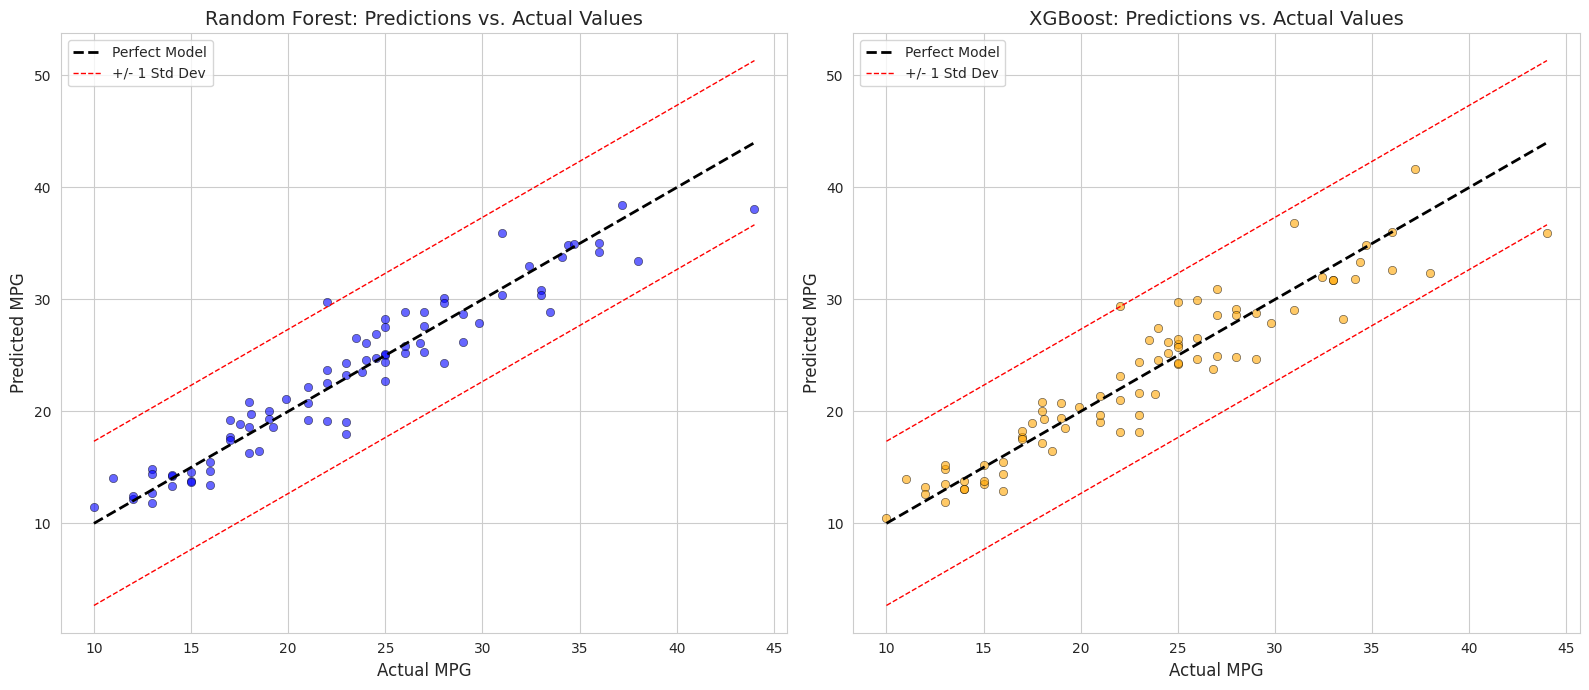

In [ ]:
# Calculate the standard deviation of the test target variable
std_y = np.std(y_test)

plt.figure(figsize=(16, 7))

# --- Random Forest Plot ---
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6, color="blue", ec='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Perfect Model")
plt.plot([y_test.min(), y_test.max()], [y_test.min() + std_y, y_test.max() + std_y], 'r--', lw=1, label="+/- 1 Std Dev")
plt.plot([y_test.min(), y_test.max()], [y_test.min() - std_y, y_test.max() - std_y], 'r--', lw=1)
plt.title("Random Forest: Predictions vs. Actual Values", fontsize=14)
plt.xlabel("Actual MPG", fontsize=12)
plt.ylabel("Predicted MPG", fontsize=12)
plt.legend()

# --- XGBoost Plot ---
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6, color="orange", ec='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Perfect Model")
plt.plot([y_test.min(), y_test.max()], [y_test.min() + std_y, y_test.max() + std_y], 'r--', lw=1, label="+/- 1 Std Dev")
plt.plot([y_test.min(), y_test.max()], [y_test.min() - std_y, y_test.max() - std_y], 'r--', lw=1)
plt.title("XGBoost: Predictions vs. Actual Values", fontsize=14)
plt.xlabel("Actual MPG", fontsize=12)
plt.ylabel("Predicted MPG", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

Visually, both plots show that the predictions cluster nicely around the "perfect model" line, confirming that both models have learned the underlying patterns in the data well. The XGBoost plot appears slightly tighter, which aligns with its better MSE and R² scores.

### Bonus: Feature Importance

A powerful feature of tree-based ensemble models is their ability to report on **feature importance**. This tells us which features the model found most predictive. Let's visualize the feature importances for both models to see what drives their predictions.

/tmp/ipython-input-14-3499258534.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances, y=feature_names, palette='viridis')
/tmp/ipython-input-14-3499258534.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances, y=feature_names, palette='plasma')


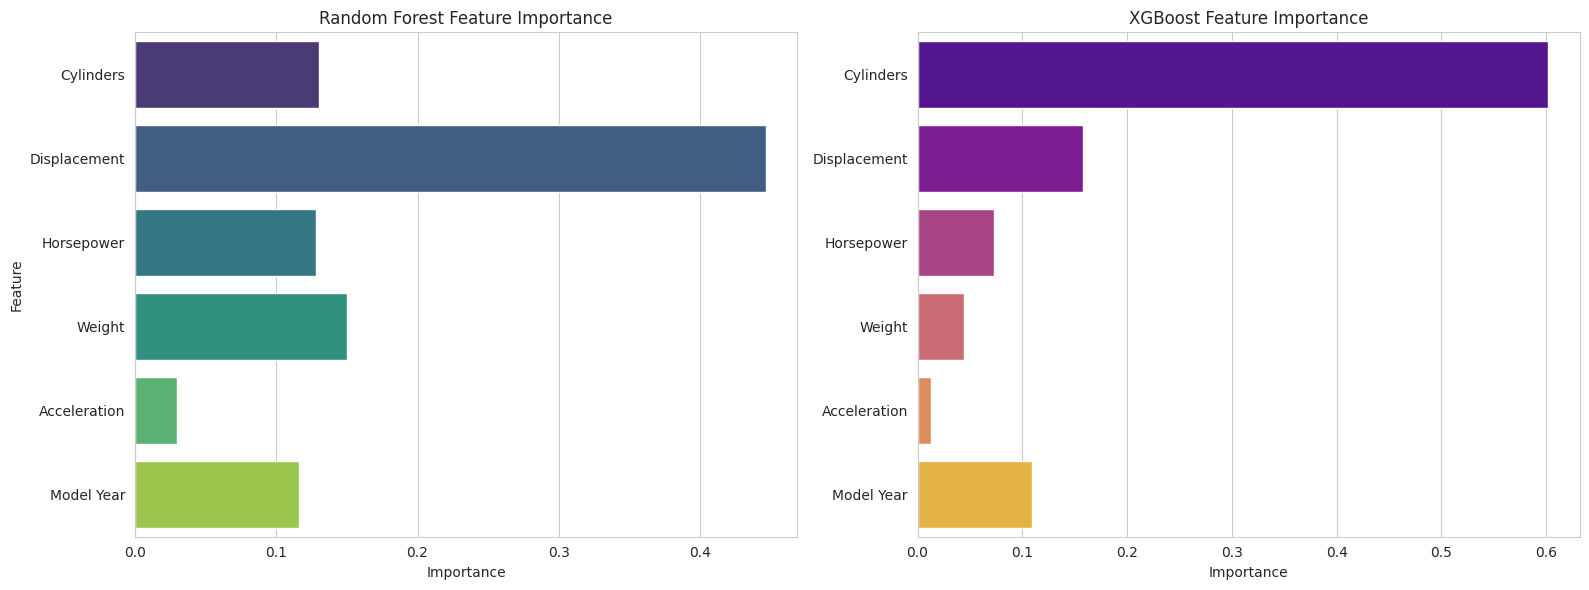

In [ ]:
# Get feature importances
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(16, 6))

# Random Forest Feature Importance
plt.subplot(1, 2, 1)
sns.barplot(x=rf_importances, y=feature_names, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# XGBoost Feature Importance
plt.subplot(1, 2, 2)
sns.barplot(x=xgb_importances, y=feature_names, palette='plasma')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('') # Hide y-label for cleaner look

plt.tight_layout()
plt.show()

While both models correctly identify that features related to a car's engine and mass are critical for predicting MPG, they often prioritize them differently. For example, XGBoost might highlight Cylinders and Displacement as most important, whereas Random Forest could place more emphasis on Displacement and Weight.
This difference in the exact ranking and weighting of features reflects their different underlying algorithms. Ultimately, both confirm the intuitive real-world logic: heavier cars with larger engines tend to have lower fuel efficiency.

### Practice Exercises

Now it's your turn to apply what you've learned.

#### Exercise 1: Guided - Tune XGBoost with More Estimators

Let's see if we can improve the XGBoost model's performance by increasing the number of estimators (trees) from 100 to 250. Fill in the missing code below to initialize, train, and evaluate a new XGBoost model.

In [ ]:
# Step 1: Initialize a new XGBoost model with n_estimators=250
xgb_model_tuned = XGBRegressor(n_estimators=250, random_state=42)

# Step 2: Fit the new model on the training data
xgb_model_tuned.fit(X_train, y_train)

# Step 3: Make predictions with the new model
y_pred_xgb_tuned = xgb_model_tuned.predict(X_test)

# Step 4: Calculate MSE and R2 for the new model
mse_xgb_tuned = mean_squared_error(y_test, y_pred_xgb_tuned)
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)

# Step 5: Print the results
print(f"Tuned XGBoost | MSE: {mse_xgb_tuned:.4f} | R²: {r2_xgb_tuned:.4f}")
print(f"Original XGBoost| MSE: {mse_xgb:.4f} | R²: {r2_xgb:.4f}")

Tuned XGBoost | MSE: 6.5983 | R²: 0.8773
Original XGBoost| MSE: 6.5718 | R²: 0.8778


<details>
<summary>Click here for the solution to Exercise 1</summary>

```python
# Step 1: Initialize a new XGBoost model with n_estimators=250
xgb_model_tuned = XGBRegressor(n_estimators=250, random_state=42)

# Step 2: Fit the new model on the training data
xgb_model_tuned.fit(X_train, y_train)

# Step 3: Make predictions with the new model
y_pred_xgb_tuned = xgb_model_tuned.predict(X_test)

# Step 4: Calculate MSE and R2 for the new model
mse_xgb_tuned = mean_squared_error(y_test, y_pred_xgb_tuned)
r2_xgb_tuned = r2_score(y_test, y_pred_xgb_tuned)

# Step 5: Print the results
print(f"Tuned XGBoost | MSE: {mse_xgb_tuned:.4f} | R²: {r2_xgb_tuned:.4f}")
print(f"Original XGBoost| MSE: {mse_xgb:.4f} | R²: {r2_xgb:.4f}")
```

</details>

#### Exercise 2: Challenge - Create a Comparative Visualization

Create a single bar chart that visually compares the **Mean Squared Error (MSE)** of all three models we have worked with:
1. Random Forest (original)
2. XGBoost (original, 100 estimators)
3. XGBoost (tuned, 250 estimators)

This will give us a clear visual summary of which model performed best. Use the `seaborn.barplot()` function.

/tmp/ipython-input-16-3785787297.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=mse_scores, palette='magma')


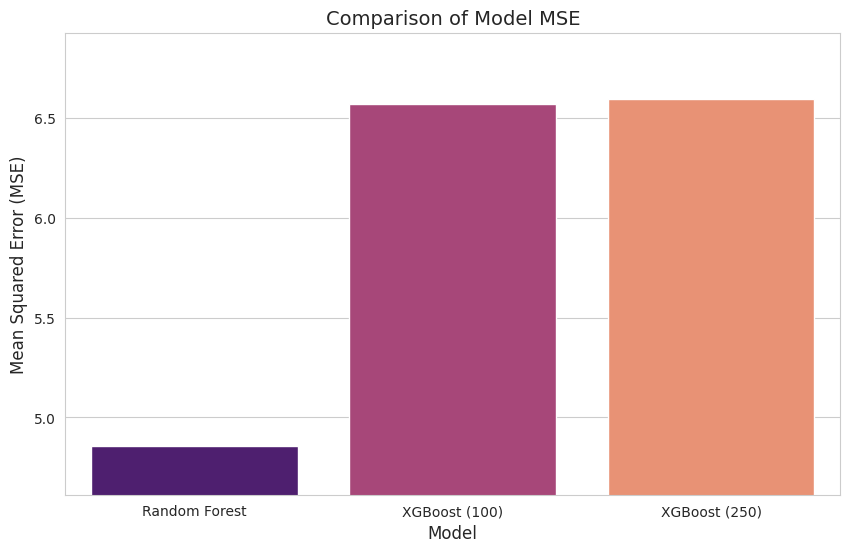

In [ ]:
# Hint: Create lists for your model names and their corresponding MSE scores
model_names = ['Random Forest', 'XGBoost (100)', 'XGBoost (250)']
mse_scores = [mse_rf, mse_xgb, mse_xgb_tuned]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=mse_scores, palette='magma')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Comparison of Model MSE', fontsize=14)
plt.ylim(bottom=min(mse_scores) * 0.95) # Adjust y-axis for better visibility
plt.show()

<details>
<summary>Click here for the solution to Exercise 2</summary>

```python
# Hint: Create lists for your model names and their corresponding MSE scores
model_names = ['Random Forest', 'XGBoost (100)', 'XGBoost (250)']
mse_scores = [mse_rf, mse_xgb, mse_xgb_tuned]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=mse_scores, palette='magma')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Comparison of Model MSE', fontsize=14)
plt.ylim(bottom=min(mse_scores) * 0.95) # Adjust y-axis for better visibility
plt.show()
```

</details>

## Conclusion

Congratulations! You have successfully completed this lab. You have learned how to load and clean a dataset, train and time two advanced regression models, evaluate their performance using metrics and visualizations, and even tune a model for better results.

The key takeaway is that while both Random Forest and XGBoost are powerful, XGBoost often provides a competitive edge in both speed and accuracy, making it a go-to choice for many data science competitions and real-world applications.

## Author

Aymen el kani

From the results, we can observe that on this dataset, **Random Forest** achieved a lower MSE and a higher R² score than the original XGBoost model, indicating better predictive accuracy on this specific test set. In terms of speed, **Random Forest** was faster during training, while **XGBoost** was faster during prediction. While the performance differences are present, the relative speed advantage of XGBoost in prediction can become more significant on larger datasets or when inference time is critical.